In [23]:
from gym.wrappers import AtariPreprocessing, FrameStack
import keras 
from keras import layers
import tensorflow as tf 
import numpy as np
import gym as gym
import random
random.seed(2212)
np.random.seed(2212)
tf.random.set_seed(2212)
from collections import deque
input_shape = [2]


# Hyperparameters
EPISODES = 560
REPLAY_MEMORY_SIZE = 1_00_000
MINIMUM_REPLAY_MEMORY = 1_000
MINIBATCH_SIZE = 32
EPSILON = 1
EPSILON_DECAY = 0.99
MINIMUM_EPSILON = 0.001
DISCOUNT = 0.99
ENV_NAME = 'BreakoutNoFrameskip-v4'
EPSILON_RANDOM_FRAMES = 50
MAX_STEPS_PER_EPISODE = 300
UPDATE_AFTER_ACTIONS = 4
UPDATE_TARGET_NETWROK = 10000
MAX_EPISODES = 100

# Environment details
env = gym.make(ENV_NAME)
env = AtariPreprocessing(env)
env = FrameStack(env,4)
env.reset()
obs = env.step(1)
print("Shape of Observation", obs)
# action_dim = env.action_space.n
# observation_dim = env.observation_space.shape

# defining the input shape and the number of outputs from the environment
input_shape = env.observation_space.shape  # Assuming self.observation_dim is a tuple
n_outputs = env.action_space.n

# Creating a simple sequential neural network model with 3 layers (400, 300, 2)
# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(400, activation='relu', input_shape=input_shape),
#     tf.keras.layers.Dense(300, activation='relu'),
#     tf.keras.layers.Dense(n_outputs, activation='linear')
# ])

num_actions = 4
def create_dueling_q_model():
    # Input layer (already adjusting to 'channels last')
    input_layer = layers.Input(shape=(84, 84, 4))
    
    # Convolutional layers
    x = layers.Conv2D(32, 8, strides=4, activation="relu")(input_layer)
    x = layers.Conv2D(64, 4, strides=2, activation="relu")(x)
    x = layers.Conv2D(64, 3, strides=1, activation="relu")(x)
    
    # Flattening the last convolutional output
    x = layers.Flatten()(x)
    
    # Dueling streams
    # State value tower - V(s)
    state_value = layers.Dense(512, activation='relu')(x)
    state_value = layers.Dense(1, activation=None)(state_value)
    
    # Action advantage tower - A(s, a)
    action_advantage = layers.Dense(512, activation='relu')(x)
    action_advantage = layers.Dense(num_actions, activation=None)(action_advantage)
    
    # Combine the state and action advantage to get the final Q-values
    # Q(s, a) = V(s) + (A(s, a) - mean(A(s, a)))
    q_values = layers.Lambda(lambda values: values[0] + (values[1] - tf.reduce_mean(values[1], axis=1, keepdims=True)),
                             output_shape=(num_actions,))([state_value, action_advantage])

    # Build the model
    model = keras.Model(inputs=input_layer, outputs=q_values)
    return model

model = create_dueling_q_model()
target_model1 = create_dueling_q_model()

# Compiling the neural network using Mean Square Error as loss function and
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=0.005))

# Cloning the model to create a target model
# target_model1 = tf.keras.models.clone_model(model)

from collections import deque
# Replay memory to store experiances of the model with the environment
replay_buffer = deque(maxlen=REPLAY_MEMORY_SIZE)

'''Defining epsilon greedy policy function to determine an action
to decide whether to explore or exploit the knowledge acquired'''
# def epsilon_greedy_policy(state, epsilon, frame_count):
    # if np.random.uniform(0, 1) < epsilon or frame_count < EPSILON_RANDOM_FRAMES:
    #     action = np.random.randint(0, num_actions)
    #     return action
    # else:
    #     ''' Look into Notebook'''
    #     # $# action = np.argmax(model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
    #     state_tensor = keras.ops.convert_to_tensor(state)
    #     state_tensor = keras.ops.expand_dims(state_tensor, 0)
    #     if state_tensor.shape == (1, 1, 84, 84, 4):  # Check if there's an extra unwanted dimension
    #         state_tensor = tf.squeeze(state_tensor, axis=1)        
    #     action_probs = model(state_tensor, training=False)
    #     # Take best action
    #     action = keras.ops.argmax(action_probs[0]).numpy()

    #     return action

def epsilon_greedy_policy(state, epsilon, frame_count):
    if np.random.uniform(0, 1) < epsilon or frame_count < EPSILON_RANDOM_FRAMES:
        action = np.random.randint(0, num_actions)
        return action
    else:
        state_tensor = keras.ops.convert_to_tensor(state)
        state_tensor = keras.ops.expand_dims(state_tensor, 0)
        
        # Correct the shape if there's an extra unwanted dimension
        if state_tensor.shape[1] == 1:  # If there's a singleton dimension at axis 1
            state_tensor = tf.squeeze(state_tensor, axis=1)

        # Transpose dimensions from (batch_size, channels, height, width) to (batch_size, height, width, channels)
        if state_tensor.shape == (1, 4, 84, 84):
            state_tensor = tf.transpose(state_tensor, [0, 2, 3, 1])

        action_probs = model.predict(state_tensor)  # Predict action probabilities
        action = np.argmax(action_probs[0])  # Take the best action
        return action
'''This function samples a batch of experiences from the replay buffer for training the model.'''
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ] 

max_reward = -999999
'''This function defines the steps the agent has to take based on the epsilon greedy policy
 and accumulates the reward'''
def play_one_step(env, state, epsilon, frame_count):
    # defining reward acquired in each episode
    global episode_reward
    # Calling epsilon greedy function to select action
    action = epsilon_greedy_policy(state, epsilon, frame_count)
    # Executing the action and returns 4 values
    next_state, reward, done, info = env.step(action)
    # $$# next_state = np.array(next_state)
    # accumulating rewards in each step of the epsiode(max=-200)
    episode_reward += reward
    env.lives = env.ale.lives()
    if (env.lives > info['lives']):
        episode_reward -= 1
        env.lives = info['lives']
    # truncating if the car reaches the flag on the mountain top within 200 steps
    # if done and episode_length < 200:
    #     # If episode is ended then we have won the game. Defining Stratagem to make the agent learn faster
    #     reward = 250 + episode_reward
    #     # save the model weights if we get a epsiode reward greater than maximum reward defined
    #     if(episode_reward > max_reward):
    #         print("Saving the model with reward", episode_reward)
    #         model.save_weights("agent"+str(episode_reward)+"_agent_.weights.h5")
    # else:
    #     # In oher cases reward will be proportional to the distance that car has travelled
    #     # from it's previous location + velocity of the car
    #     reward = 5*abs(next_state[0] - state[0]) + 3*abs(state[1])

    # append this result to the replay buffer(experince replay)
    replay_buffer.append((state, action, reward, next_state, done))

    return next_state, action, episode_reward, max_reward, done, info



np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-1)
loss_fn = tf.keras.losses.mean_squared_error

def training_step(batch_size):

    # Randomly sample a batch of experiences from the replay buffer
    minibatch = random.sample(replay_buffer, MINIBATCH_SIZE)
    # Initialize lists to store the current and next states
    X_cur_states = []
    X_next_states = []

    # Populate the current and next states lists with data from the sampled experiences
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        
        X_cur_states.append(cur_state)
        X_next_states.append(next_state)

    # Convert the lists to arrays
    

    X_cur_states = np.array(X_cur_states)
    X_next_states = np.array(X_next_states)
    X_cur_states = X_cur_states.transpose(0, 2, 3, 1)
    X_next_states = X_next_states.transpose(0, 2, 3, 1)
    
    # Initialize an array to store the Q values for the current state-action pairs
    cur_action_values = model.predict(X_cur_states, verbose =0)

    # Use the target model to predict the Q values for the next states
    next_action_values = target_model1.predict(X_next_states, verbose=0)
    
    '''Update the Q values for the current state-action pairs based on the rewards 
       and the maximum predicted Q values for the next states'''
    for index, sample in enumerate(minibatch):
        cur_state, action, reward, next_state, done = sample
        if not done:
            # if episode is not done then we have to calculate the Q value using Bellman's equation
            # Q(st, at) = rt + DISCOUNT * max(Q(s(t+1), a(t+1)))
            cur_action_values[index][action] = reward + DISCOUNT * np.amax(next_action_values[index])
        else:
            # if episode is done then Q value will be the reward
            # Q(st, at) = rt
            cur_action_values[index][action] = reward
            
    # train the agent with new Q values for the states and the actions
    model.fit(X_cur_states, cur_action_values, verbose=0)
    
# Initialize lists to store Q-values, positions, velocities, and actions taken
q_values = []
positions = []
velocities = []
actiion_taken = []
frame_count =0

# Loop through the episodes
for episode in range(MAX_EPISODES):
    # Reset the environment for the state to be reset
    state = env.reset()
    # print(state.shape)
    state = np.array(state) # $$# Will see for env.reset
    # done = False
    episode_reward = 0
    episode_length = 0

    # Run through different sets of steps untill 200 steps are completed or the car reaches the flag
    for timestep in range(1,MAX_STEPS_PER_EPISODE):
        frame_count += 1
        # Increment the episode length
        episode_length += 1

        # Play one step in the environment and get the next state, action, reward, max reward, done status, and info
        next_state, action, reward, max_reward, done, info  = play_one_step(env, state, EPSILON, frame_count)
        # Append the position, velocity, and action to their respective lists
        # positions.append(next_state[0])
        # velocities.append(next_state[1]) # $$# mgight need it later
        # actiion_taken.append(action)

        # Update the current state to the next state
        state = next_state

        # If the replay buffer is not large enough, skip the training step
        if(len(replay_buffer) < MINIMUM_REPLAY_MEMORY):
            continue
        elif (frame_count % UPDATE_AFTER_ACTIONS == 0):
            training_step(batch_size)

    # print("training ends")

    # Update the maximum reward if the current reward is greater
    max_reward = max(reward, max_reward)

    # Print the episode number, episodic reward, maximum reward, and epsilon
    print('Episode', episode, 'Episodic Reward', reward, 'Maximum Reward', max_reward, 'EPSILON', EPSILON)
    rewards.append(reward)
    state = np.array([(state)])
    state= state.transpose(0, 2, 3, 1)
    # print(state.shape)
    # Append the mean Q-value of the current state to the Q-values list
    q_values.append(np.mean(model.predict(state, verbose=0)[0]))
    
    # Every 20 episodes, update the weights of the target model with the weights of the training model
    if frame_count % UPDATE_TARGET_NETWROK == 0:
        target_model1.set_weights(model.get_weights())
    
    # If epsilon is greater than the minimum epsilon and the replay buffer is large enough, decay epsilon
    if(EPSILON > MINIMUM_EPSILON and len(replay_buffer) > MINIMUM_REPLAY_MEMORY):
        EPSILON *= EPSILON_DECAY

    if episode >= MAX_EPISODES:
        print("Stopped at eisode {}!".format(episode_length))
        break

Shape of Observation (<gym.wrappers.frame_stack.LazyFrames object at 0x000001D5A17C43B0>, 0.0, False, {'lives': 5, 'episode_frame_number': 17, 'frame_number': 17})
Episode 0 Episodic Reward 1.0 Maximum Reward 1.0 EPSILON 1
Episode 1 Episodic Reward 0.0 Maximum Reward 1.0 EPSILON 1
Episode 2 Episodic Reward 0.0 Maximum Reward 1.0 EPSILON 1
Episode 3 Episodic Reward 2.0 Maximum Reward 2.0 EPSILON 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Episode 4 Episodic Reward 2.0 Maximum Reward 2.0 EPSILON 0.99
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Episode 5 Episodic Reward 0.0 Maximum Reward 2.0 EPSILON 0.9801
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━

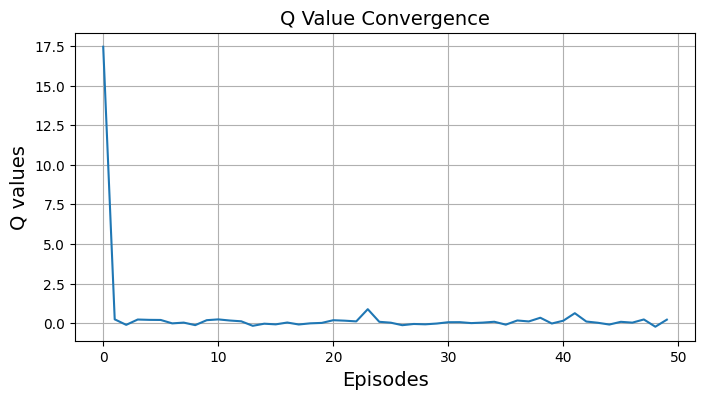

In [9]:
# model.set_weights(best_weights)
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4))
plt.plot(q_values)
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Q values", fontsize=14)
plt.title("Q Value Convergence", fontsize=14)
plt.grid(True)
plt.show()

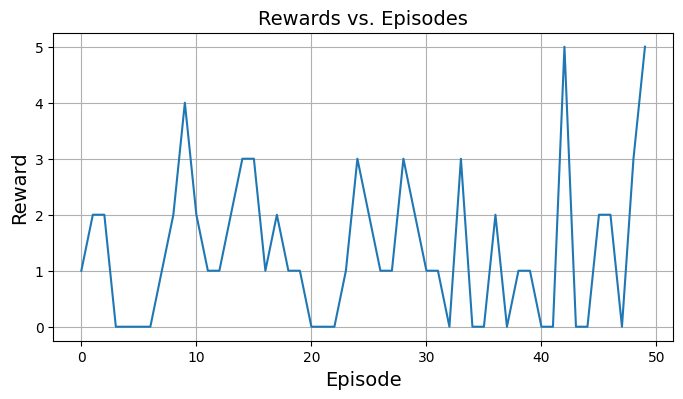

In [10]:
# model.set_weights(best_weights)
import matplotlib.pyplot as plt 
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Rewards vs. Episodes", fontsize=14)
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Moving average over 50 episodes with 5 window size')

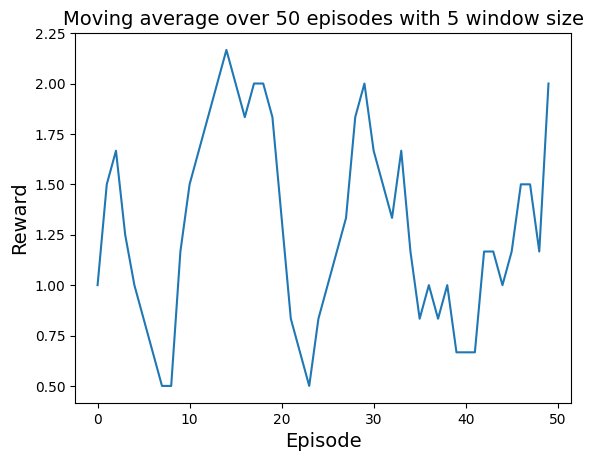

In [13]:
mean_rewards = np.zeros(50)
for t in range(50):
    mean_rewards[t] = np.mean(rewards[max(0, t-5):(t+1)])
plt.plot(mean_rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.title("Moving average over 50 episodes with 5 window size", fontsize=14)

https://github.com/SergeyGasparyan/ai-for-game-playing/blob/main/src/breakout_game.py

In [2]:
# import pygame as pg

# SCREEN_SIZE = 424, 430

# BRICK_HEIGHT, BRICK_WIDTH = 13, 32

# PADDLE_HEIGHT, PADDLE_WIDTH = 8, 50
# PADDLE_Y = SCREEN_SIZE[1] - PADDLE_HEIGHT - 10
# MAX_PADDLE_X = SCREEN_SIZE[0] - PADDLE_WIDTH

# BALL_DIAMETER = 12
# BALL_RADIUS = BALL_DIAMETER // 2
# MAX_BALL_X = SCREEN_SIZE[0] - BALL_DIAMETER
# MAX_BALL_Y = SCREEN_SIZE[1] - BALL_DIAMETER

# NUM_BRICKS_VERTICAL = 11
# NUM_BRICKS_HORIZONTAL = 12

# BLACK = (0, 0, 0)
# WHITE = (255, 255, 255)
# BLUE = (0, 0, 255)
# PADDLE_COLOR = (129, 133, 137)
# BRICK_COLOR = (153, 255, 204)

# FPS = 60

# pg.init()
# screen = pg.display.set_mode(SCREEN_SIZE)
# pg.display.set_caption("Breakout - Atari")
# clock = pg.time.Clock()


# class Breakout:
#     def __init__(self, vel=12):
#         self.capture = 0
#         self.vel = vel
#         self.ball_vel = [vel, -vel]
#         self.reward = 0.1
#         self.terminal = False

#         self.paddle = pg.Rect(
#             SCREEN_SIZE[1] // 2, PADDLE_Y, PADDLE_WIDTH, PADDLE_HEIGHT
#         )
#         self.ball = pg.Rect(
#             SCREEN_SIZE[1] // 2 + 10,
#             PADDLE_Y - BALL_DIAMETER,
#             BALL_DIAMETER,
#             BALL_DIAMETER,
#         )
#         self.create_bricks()

#     def create_bricks(self):
#         self.bricks = []
#         y_ofs = 20
#         for _ in range(NUM_BRICKS_VERTICAL):
#             x_ofs = 15

#             for _ in range(NUM_BRICKS_HORIZONTAL):
#                 self.bricks.append(pg.Rect(x_ofs, y_ofs, BRICK_WIDTH, BRICK_HEIGHT))
#                 x_ofs += BRICK_WIDTH + 1

#             y_ofs += BRICK_HEIGHT + 1

#     def draw_bricks(self):
#         for i, brick in enumerate(self.bricks):
#             pg.draw.rect(screen, BRICK_COLOR, brick)

#     def draw_paddle(self):
#         pg.draw.rect(screen, PADDLE_COLOR, self.paddle)

#     def draw_ball(self):
#         pg.draw.circle(
#             screen,
#             WHITE,
#             (self.ball.left + BALL_RADIUS, self.ball.top + BALL_RADIUS),
#             BALL_RADIUS,
#         )

#     def check_input(self, input_action):
#         # 0: LEFT, 1: Right
#         if input_action[0] == 1:
#             self.paddle.left -= self.vel
#             if self.paddle.left < 0:
#                 self.paddle.left = 0

#         elif input_action[1] == 1:
#             self.paddle.left += self.vel
#             if self.paddle.left > MAX_PADDLE_X:
#                 self.paddle.left = MAX_PADDLE_X

#     def move_ball(self):
#         self.ball.left += self.ball_vel[0]
#         self.ball.top += self.ball_vel[1]

#         if self.ball.left <= 0:
#             self.ball.left = 0
#             self.ball_vel[0] = -self.ball_vel[0]
#         elif self.ball.left >= MAX_BALL_X:
#             self.ball.left = MAX_BALL_X
#             self.ball_vel[0] = -self.ball_vel[0]

#         if self.ball.top < 0:
#             self.ball.top = 0
#             self.ball_vel[1] = -self.ball_vel[1]
#         elif self.ball.top >= MAX_BALL_Y:
#             self.ball.top = MAX_BALL_Y
#             self.ball_vel[1] = -self.ball_vel[1]

#     def take_action(self, input_action):
#         pg.event.pump()
#         for event in pg.event.get():
#             if event.type == pg.QUIT:
#                 pg.quit()
#                 quit()

#         screen.fill(BLACK)
#         self.check_input(input_action)
#         self.move_ball()

#         # Handle Collisions
#         for brick in self.bricks:
#             if self.ball.colliderect(brick):
#                 self.reward = 2
#                 self.ball_vel[1] = -self.ball_vel[1]
#                 self.bricks.remove(brick)
#                 break

#         if len(self.bricks) == 0:
#             self.terminal = True
#             self.__init__()

#         if self.ball.colliderect(self.paddle):
#             self.ball.top = PADDLE_Y - BALL_DIAMETER
#             self.ball_vel[1] = -self.ball_vel[1]
#         elif self.ball.top > self.paddle.top:
#             self.terminal = True
#             self.__init__()
#             self.reward = -2

#         self.draw_bricks()
#         self.draw_ball()
#         self.draw_paddle()

#         image_data = pg.surfarray.array3d(pg.display.get_surface())

#         pg.display.update()
#         clock.tick(FPS)

#         return image_data, self.reward, self.terminal

pygame 2.1.0 (SDL 2.0.16, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [1]:
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.number_of_actions = 2
        self.gamma = 0.99
        self.final_epsilon = 0.05
        self.initial_epsilon = 0.1
        self.number_of_iterations = 2000000
        self.replay_memory_size = 750000
        self.minibatch_size = 32
        self.explore = 3000000

        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, 4, 2)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.fc4 = nn.Linear(7 * 7 * 64, 512)
        self.fc5 = nn.Linear(512, self.number_of_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x.view(x.size(0), -1)))

        return self.fc5(x)

In [8]:
import torch
# import Breakout
from utils import device, preprocessing
from models import NeuralNetwork


def test(model):
    game_state = Breakout()

    # initial action is do nothing
    action = torch.zeros([model.number_of_actions], dtype=torch.float32).to(device)
    action[0] = 1
    image_data, _, _ = game_state.take_action(action)
    image_data = preprocessing(image_data)
    state = torch.cat((image_data, image_data, image_data, image_data)).unsqueeze(0)

    while True:
        # get output from the neural network
        output = model(state)[0]
        action = torch.zeros([model.number_of_actions], dtype=torch.float32)

        # get action
        action_index = torch.argmax(output)
        action[action_index] = 1

        # get next state
        image_data_1, _, _ = game_state.take_action(action)
        image_data_1 = preprocessing(image_data_1)
        state_1 = torch.cat((state.squeeze(0)[1:, :, :], image_data_1)).unsqueeze(0)

        # set state to be state_1
        state = state_1


if __name__ == "__main__":
    model = NeuralNetwork()
    model.load_state_dict(torch.load('model_weights/best.pth').state_dict())
    test(model.eval().to(device))

ModuleNotFoundError: No module named 'utils'

: 

In [ ]:
import os
import time
import torch
import random
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
from collections import deque
from models import NeuralNetwork
from breakout_game import Breakout
from utils import device, init_weights, preprocessing


def train(model, start, lr=0.0003, optim_name='adam', loss_name='mse', num_iter_save=1000):
    # define optimizer
    if optim_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optim_name == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr)

    # initialize error loss
    if loss_name == 'mse':
        criterion = nn.MSELoss()
    elif loss_name == 'crossentropy':
        criterion = nn.CrossEntropyLoss()

    # instantiate game
    game_state = Breakout()

    # initialize replay memory
    replay_buffer = deque()

    # initial action
    action = torch.zeros([model.number_of_actions], dtype=torch.float32).to(device)
    image_data, reward, terminal = game_state.take_action(action)
    image_data = preprocessing(image_data)
    state = torch.cat((image_data, image_data, image_data, image_data)).unsqueeze(0)

    # initialize epsilon value
    epsilon = model.initial_epsilon
    iteration = 0

    # main infinite loop
    while iteration < model.number_of_iterations:
        # get output from the neural network
        output = model(state)[0] # Output size = torch.Size([2]) tensor([-0.0278,  1.7244]
        #output = model(state)

        # initialize action
        action = torch.zeros([model.number_of_actions], dtype=torch.float32)

        # epsilon greedy exploration
        random_action = random.random() <= epsilon

        # Pick action --> random or index of maximum q value
        action_index = [torch.randint(model.number_of_actions, torch.Size([]), dtype=torch.int)
                        if random_action
                        else torch.argmax(output)][0].to(device)

        action[action_index] = 1

        if epsilon > model.final_epsilon:
            epsilon -= (model.initial_epsilon - model.final_epsilon) / model.explore

        # get next state and reward
        image_data_1, reward, terminal = game_state.take_action(action)
        image_data_1 = preprocessing(image_data_1)

        state_1 = torch.cat((state.squeeze(0)[1:, :, :], image_data_1)).unsqueeze(0)
        action = action.unsqueeze(0)
        reward = torch.from_numpy(np.array([reward], dtype=np.float32)).unsqueeze(0).to(device)

        # save transition to replay memory
        replay_buffer.append((state, action, reward, state_1, terminal))

        # if replay memory is full, remove the oldest transition
        if len(replay_buffer) > model.replay_memory_size:
            replay_buffer.popleft()

        # sample random mini_batch
        # it picks k unique random elements, a sample, from a sequence: random.sample(population, k)
        mini_batch = random.sample(replay_buffer, min(len(replay_buffer), model.minibatch_size))

        # unpack mini_batch
        state_batch   = torch.cat(tuple(d[0] for d in mini_batch)).to(device)
        action_batch  = torch.cat(tuple(d[1] for d in mini_batch)).to(device)
        reward_batch  = torch.cat(tuple(d[2] for d in mini_batch)).to(device)
        state_1_batch = torch.cat(tuple(d[3] for d in mini_batch)).to(device)

        # get output for the next state
        output_1_batch = model(state_1_batch)

        # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q) Target Q value Bellman equation.
        y_batch = torch.cat(tuple(reward_batch[i] if mini_batch[i][4]
                                  else reward_batch[i] + model.gamma * torch.max(output_1_batch[i])
                                  for i in range(len(mini_batch))))

        q_value = torch.sum(model(state_batch) * action_batch, dim=1)

        optimizer.zero_grad()
        y_batch = y_batch.detach()

        # calculate loss
        loss = criterion(q_value, y_batch)

        # do backward pass
        loss.backward()
        optimizer.step()

        # set state to be state_1
        state = state_1
        iteration += 1

        if iteration % num_iter_save == 0:
            print('Saving the model')
            torch.save(model, f"model_weights/model_{iteration}.pth")

        elapsed_time = time.time() - start
        elapsed_minutes = int(elapsed_time // 60)
        elapsed_seconds = int(elapsed_time % 60)

        print(f"Iteration: {iteration} Elapsed time: {elapsed_minutes}:{elapsed_seconds} epsilon: {epsilon:.5f} action: {action_index.cpu().item()} Reward: {reward.cpu().numpy()[0][0]:.1f}")


if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    parser.add_argument('--lr', type=float, default=0.0003, help="learning rate")
    parser.add_argument('--optim', type=str, default='adam', help="optimzer: adam, or sgd")
    parser.add_argument('--loss', type=str, default='mse', help="loss function: mse, or cross_entropy")
    parser.add_argument('--num_iter_save', type=int, default=1000, help="number of iterations to save the model checkpoint")

    args = parser.parse_args()

    os.makedirs('model_weights/', exist_ok=True)
    model = NeuralNetwork()
    if os.path.exists('model_weights/best.pth'):
        model = torch.load('model_weights/best.pth')
    else:
        model.apply(init_weights)

    model = model.train().to(device)

    start = time.time()
    train(model, start, args.lr, args.optim, args.loss, args.num_iter_save)

In [ ]:
import cv2
import torch
import torch.nn as nn
import numpy as np


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def preprocessing(image):
	image_data = cv2.cvtColor(cv2.resize(image, (84, 84)), cv2.COLOR_BGR2GRAY)
	image_data[image_data > 0] = 255
	image_data = np.reshape(image_data,(84, 84, 1))
	image_tensor = image_data.transpose(2, 0, 1)
	image_tensor = image_tensor.astype(np.float32)
	image_tensor = torch.from_numpy(image_tensor).to(device)

	return image_tensor


def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Linear:
        torch.nn.init.uniform(m.weight, -0.01, 0.01)
        m.bias.data.fill_(0.01)